In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from torch import nn
import torch
import seaborn as sns
from torch import optim
import torch.nn.functional as F
import math

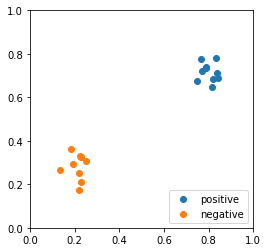

In [2]:
data_x_pos = np.random.multivariate_normal([0.8, 0.7], [[0.001, 0], [0, 0.003]], 10)
data_x_neg = np.random.multivariate_normal([0.2, 0.3], [[0.001, 0], [0, 0.003]], 10)
data_y_pos = np.ones(10)
data_y_neg = np.zeros(10)
data_x = np.vstack([data_x_pos, data_x_neg])
data_y = np.hstack([data_y_pos, data_y_neg])
fig, ax = plt.subplots(figsize=(4, 4))
plt.scatter(data_x_pos[:,0], data_x_pos[:,1], label='positive')
plt.scatter(data_x_neg[:,0], data_x_neg[:,1], label='negative')
ax.legend(loc='lower right')
ax.set_xlim((0,1))
ax.set_ylim((0,1))

data_x = torch.from_numpy(data_x).float()
data_y = torch.from_numpy(data_y).float()

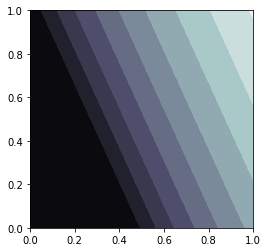

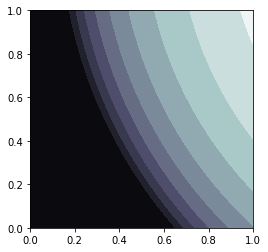

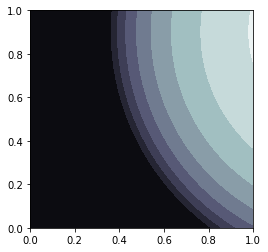

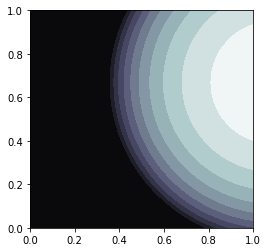

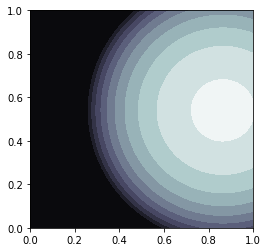

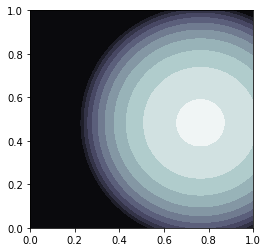

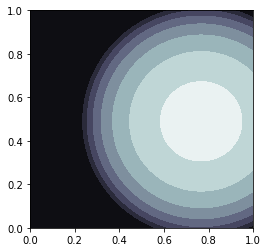

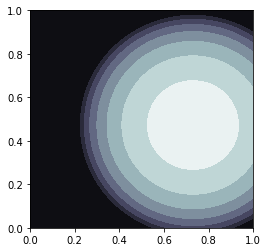

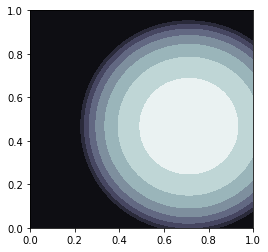

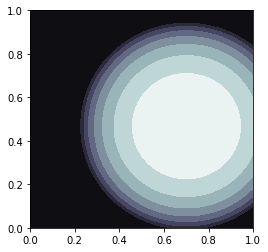

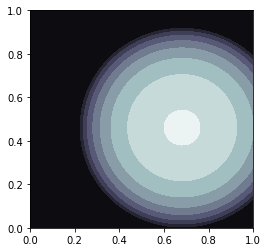

In [47]:
class ReLog(nn.Module):
    def forward(self, input):
        n = 5
        return torch.log(F.relu(input) + 1/n) / math.log(n) + 1

radius0 = 0.3
multiplier = 0
    
class Spherical(nn.Linear):
    def forward(self, input):
        output = super(Spherical, self).forward(input)
        a = multiplier/(radius0)**2
        output += -a * (input*input).mean(axis=1, keepdim=True) + a/4
        return output
    
def plot_model(model):
    val_x = np.linspace(0, 1, 100)
    val_y = np.linspace(0, 1, 100)
    val_x, val_y = np.meshgrid(val_x, val_y)
    input = np.stack([val_x.flatten(), val_y.flatten()], axis=-1)
    val_z = model(torch.from_numpy(input).float()).detach().numpy().reshape(val_x.shape)
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.contourf(val_x, val_y, val_z, 10, cmap=plt.cm.bone, origin='lower')

def demo_model(regularization=lambda m: 0, use_spherical=False, 
               n_epochs=100, lr=0.1, plot_interval=10):
    global multiplier
    model = nn.Sequential(
        Spherical(2, 1) if use_spherical else nn.Linear(2, 1),
        nn.ReLU(),
        ReLog()
    )
    multiplier = 0
    linear_module = model[0]
    with torch.no_grad():
        # stabilize learning
        linear_module.weight.abs_()
        linear_module.bias.fill_(0)
    # train
    lr = 0.5
    loss_func = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    plt.ion()
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        pred = model(data_x)
        loss = loss_func(pred.flatten(), data_y) + regularization(linear_module)
        loss.backward()
        optimizer.step()
        if plot_interval > 0 and epoch % plot_interval == 0:
            plot_model(model)
        if use_spherical:
            multiplier = min(multiplier + 0.01, 1)
    plot_model(model)
    plt.ioff()
    return model

model = demo_model(lambda m: 0, use_spherical=True, n_epochs=100)

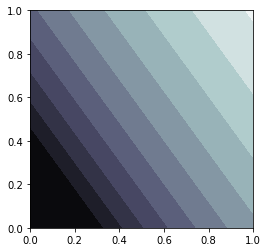

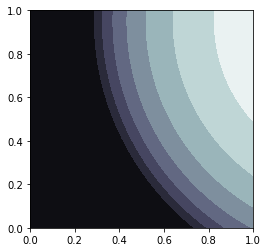

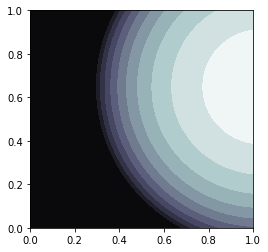

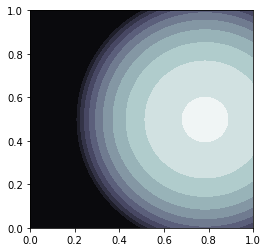

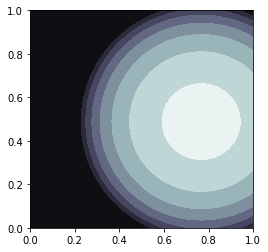

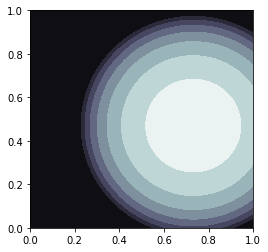

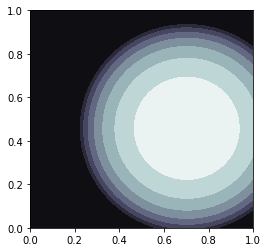

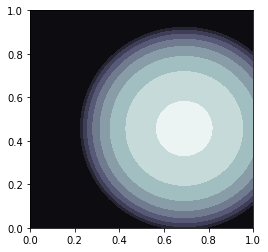

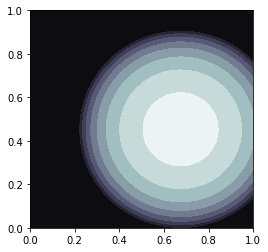

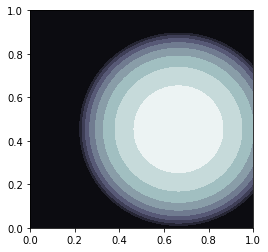

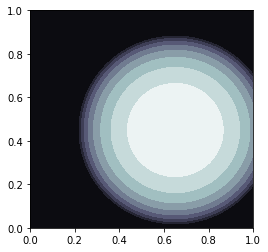

In [48]:
radius0 = 0.25
model = demo_model(lambda m: 0, use_spherical=True, n_epochs=100)

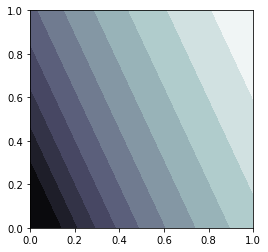

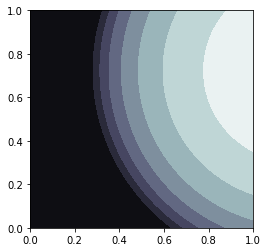

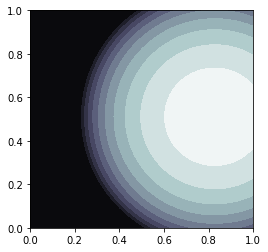

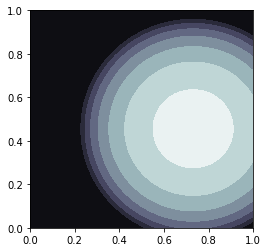

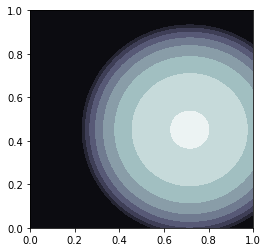

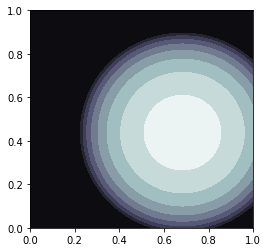

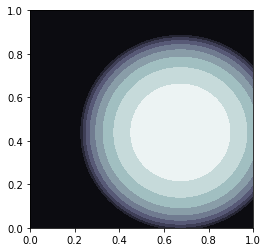

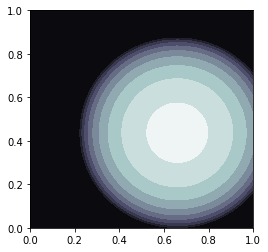

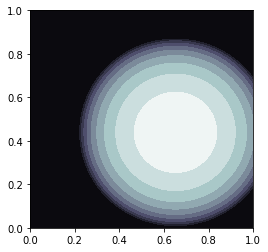

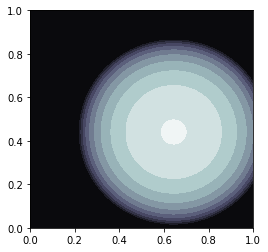

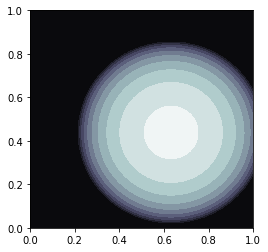

In [49]:
radius0 = 0.2
model = demo_model(lambda m: 0, use_spherical=True)

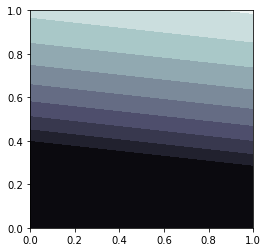

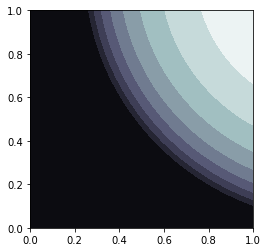

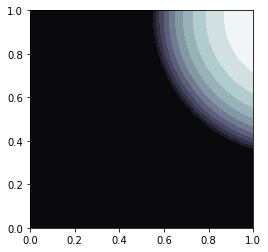

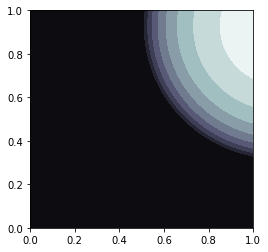

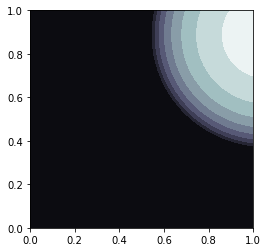

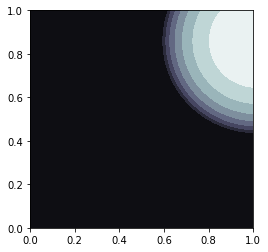

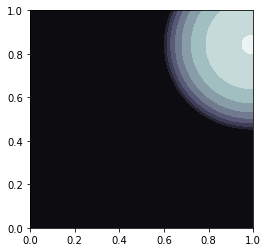

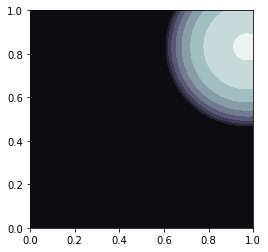

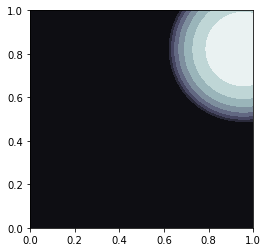

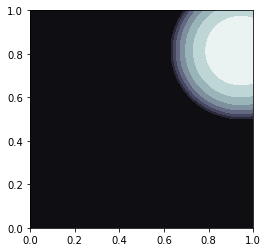

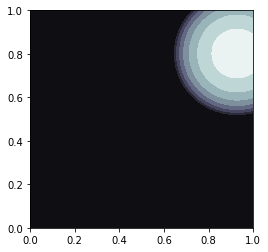

In [51]:
radius0 = 0.2
model = demo_model(lambda m: 0.1*m.bias, use_spherical=True)